In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from hnc_pseudopotential import  HNC_solver

# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}

Define physical constants

# Check ALL Tei stuff

In [38]:
m_e = 1
m_p = 1833.274
eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
Kelvin = 8.61732814974493e-5*eV #Similarly, 1 Kelvin = 3.167e-6... in natural units 
aB = 5.29177210903e-11 # Bohr radius in m

π = np.pi
# [AU]
# ni = 6e20*1e6*aB**3
# ri = (4/3*π*ni)**(-1/3)

ri=3
ni = (4/3*π*ri**3)**-1

Te   = 1*eV 
Ti   = 1*eV 

βe   = 1/Te
βi   = 1/Ti

Zstar = 3#

Z, A = 13, 27
m_i = m_p*A
μ_ei = m_i*m_e/(m_e+m_i) #reduced mass
Tie = μ_ei * (Te/m_e + Ti/m_i) #thermal velocity defined Tei
βie = 1/Tie

ne = Zstar*ni
re = (4/3*π*ne)**(-1/3)

E_F = 1/(2*m_e) * (3*π**2 * ne)**(2/3)
v_F = np.sqrt(2*E_F/m_e)
θ   = Te/E_F

lambda_TF = np.sqrt( Te / (4*np.pi*ne)  )

Λe   = np.sqrt(  βe*2*π /m_e )
Λeff = np.sqrt(6*π) / np.sqrt( 3*Te/m_e + 0.6*v_F**2)/m_e

Λe_star  = Λeff/ri
print("Λee = {0:.3f}".format(Λe_star))
Γee = βe/ri 
Γei = -Zstar*βie/ri
Γii = Zstar**2*βi/ri 


print("Γii={0:.1f}, Γie={1:.1f}, Γee={2:.1f} ".format(Γii, Γei, Γee))
print("r_i={0:.1f}".format(ri))
print("r_e={0:.1f}".format(re))
print("θ  ={0:.2e}".format(θ))

def βv_Yukawa(r):
    return Γii/r * np.exp(-r*ri/lambda_TF)

Λee = 1.836
Γii=81.6, Γie=-27.2, Γee=9.1 
r_i=3.0
r_e=2.1
θ  =8.63e-02


Plug into get potentials

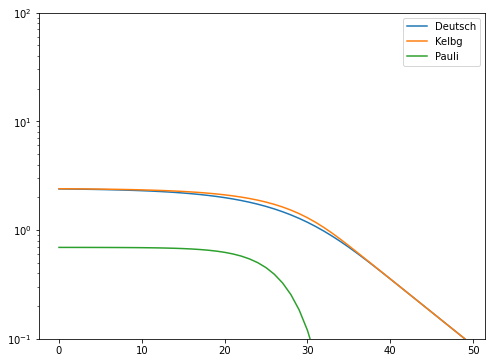

In [39]:
from scipy.special import erfc

# Build Components for QSP's

def βv_Deutsch(Γ, r):
    return Γ/r* ( 1 -  np.exp(-np.sqrt(2)*π*r/Λe_star) )

# Kelbg looks really weird??
def βv_Kelbg(Γ,r):
    return Γ/r*( 1 - np.exp(-2*π*r**2/Λe_star**2)+ np.sqrt(2)*π*r/Λe_star*erfc(np.sqrt(2*π)*r/Λe_star))

def βv_Pauli(r):
    return  np.log(2) * np.exp(-4*π* r**2 /( Λe_star**2))

def βv_Pauli(r):
    return  np.log(2) * np.exp(-4*π* r**2 /( Λe_star**2))


######### Build Actual QSP's

def βvee(r):
    return βv_Kelbg(Γee,r) + βv_Pauli(r)

def βvei(r):
    return βv_Kelbg(Γei,r)

# def βvei_atomic(r):
#     r_c = 3/5 #3/5 r_s in linear n_b(r) model
#     return np.heaviside(r - r_c,0.5) * βvei(r)

def βvii(r):
    return Γii/r 

fig, ax = plt.subplots(figsize=(8,6),facecolor='w')

xs = np.geomspace(1e-2,10)
ax.plot(βv_Deutsch(1,xs),label='Deutsch')
ax.plot(βv_Kelbg(1,xs),label='Kelbg')
ax.plot(βv_Pauli(xs),label='Pauli')
ax.set_yscale('log')
ax.set_ylim(1e-1,1e2)
ax.legend()

First, we initialize the hnc

In [48]:
from scipy.interpolate import interp1d
N_species = 3
Gamma = np.array(  [[Γii,  Γei, Γei],
                    [Γei,  Γee, Γee],
                    [Γei,  Γee, Γee]])


N_bins = 1000

names = ["Ion", "Free electrons", "Bound electrons" ] 
names = ["i", "f", "b" ] 
kappa = 1
rho = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi), (Z - Zstar)*3/(4*np.pi) ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-6,
                 kappa_multiscale=1, rho = rho, num_iterations=int(1e3), 
                 R_max=10, N_bins=N_bins, names=names, dst_type=3)#,
                 #fixed_h_species=[(0,2),(2,0)])

# ### add fixed h/g
# hnc2.fixed_h_r_matrix = np.zeros((N_species,  N_species, N_bins))

# file="/home/zach/plasma/atomic_forces/average_atom/data/Al_NPA_TFD_R3.0e+01_rs3.0e+00_T1.0e+00eV_Zstar4.7.dat"
# AA_data = pd.read_csv(file, header=2, delim_whitespace=True)
# r_AA = AA_data['r[AU]']/ri
# nf_AA = AA_data['nf[AU]']*ri**3
# nb_AA = AA_data['nb[AU]']*ri**3
# hnc2.fixed_h_r_matrix[0,2] = interp1d(r_AA, nb_AA,bounds_error=False, fill_value='extrapolate')(hnc2.r_array)-1
# hnc2.fixed_h_r_matrix[2,0] = hnc2.fixed_h_r_matrix[0,2]
# hnc2.update_fixed_h(hnc2.h_r_matrix)


In [49]:
βu_r_matrix = np.array([[βvii(hnc2.r_array), βvei(hnc2.r_array), βvei(hnc2.r_array)],
                        [βvei(hnc2.r_array), βvee(hnc2.r_array), βvee(hnc2.r_array)],
                        [βvei(hnc2.r_array), βvee(hnc2.r_array), βvee(hnc2.r_array)]])

hnc2.set_βu_matrix(βu_r_matrix)
hnc2.initialize_c_k()
hnc2.set_C_matrix()

In [50]:
hnc2.HNC_solve(alpha=1e-5, h_max=1e4)

0: Err in h_r: 4.361
1: Err in h_r: 55.294
2: Err in h_r: 350.491
3: Err in h_r: 745.180
4: Err in h_r: 976.025
5: Err in h_r: 1152.567
6: Err in h_r: 1294.274
7: Err in h_r: 1417.284
8: Err in h_r: 1523.465
9: Err in h_r: 1621.110
10: Err in h_r: 1710.016
11: Err in h_r: 1790.012
12: Err in h_r: 1862.845
13: Err in h_r: 1928.616
14: Err in h_r: 1989.154
15: Err in h_r: 2046.026
16: Err in h_r: 2100.155
17: Err in h_r: 2145.449
18: Err in h_r: 2190.084
19: Err in h_r: 2229.707
20: Err in h_r: 2265.132
21: Err in h_r: 2298.428
22: Err in h_r: 2329.323
23: Err in h_r: 2357.647
24: Err in h_r: 2383.610
25: Err in h_r: 2407.777
26: Err in h_r: 2430.742
27: Err in h_r: 2450.739
28: Err in h_r: 2468.281
29: Err in h_r: 2486.146
30: Err in h_r: 2500.586
31: Err in h_r: 2514.591
32: Err in h_r: 2526.209
33: Err in h_r: 2538.195
34: Err in h_r: 2546.163
35: Err in h_r: 2554.371
36: Err in h_r: 2562.400
37: Err in h_r: 2566.861
38: Err in h_r: 2570.298
39: Err in h_r: 2572.417
40: Err in h_r: 25

KeyboardInterrupt: 

In [ ]:
hnc2.plot_species_convergence()

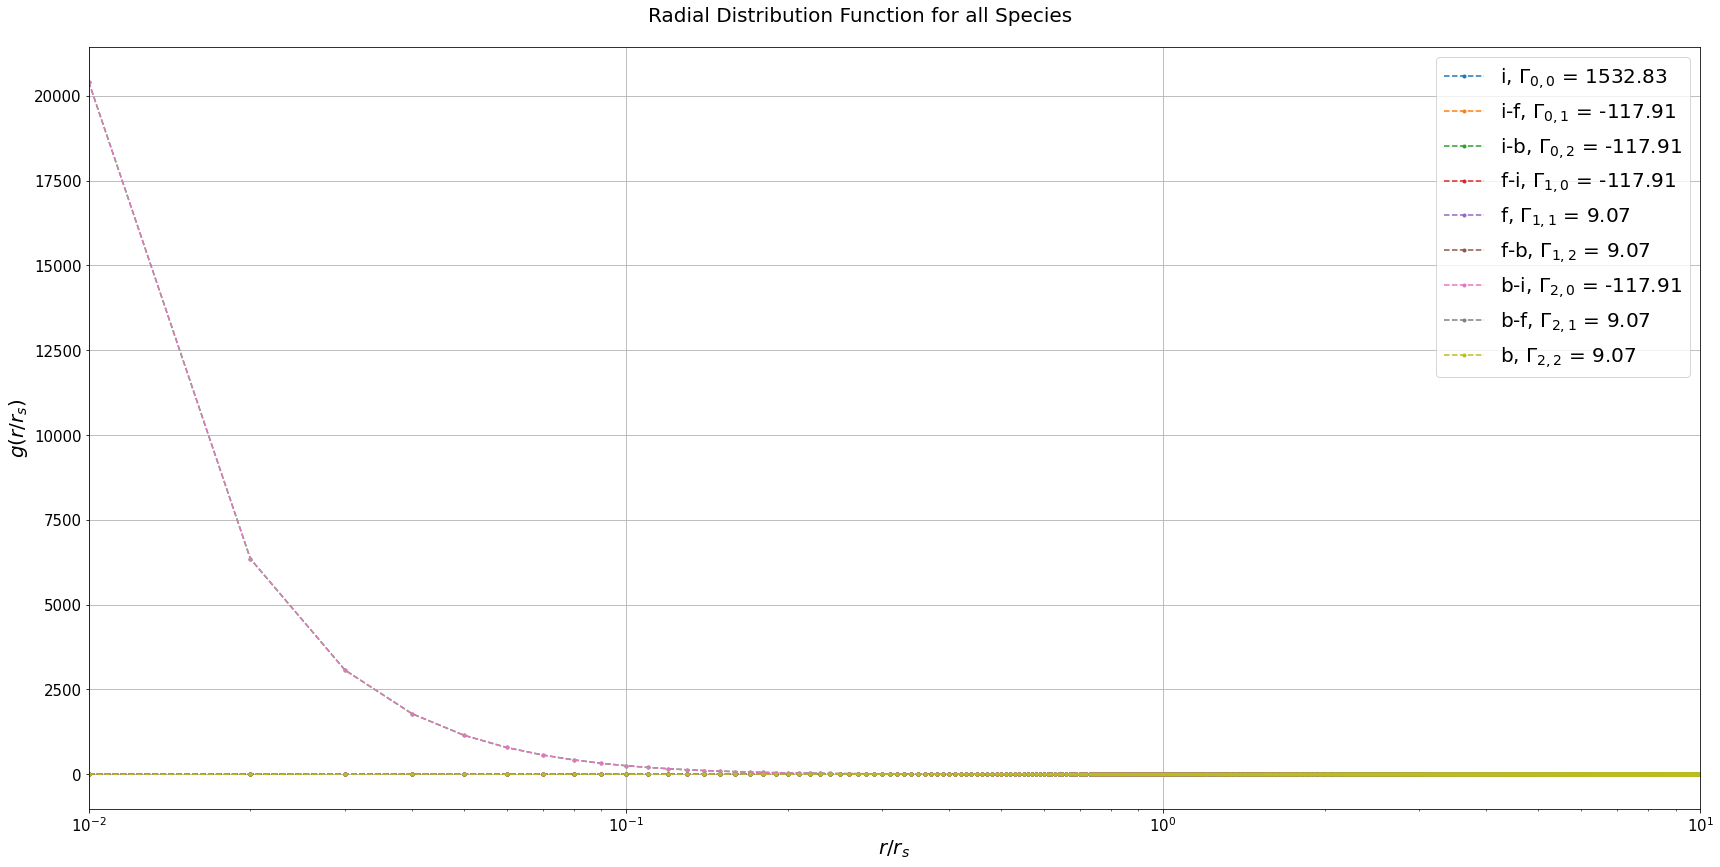

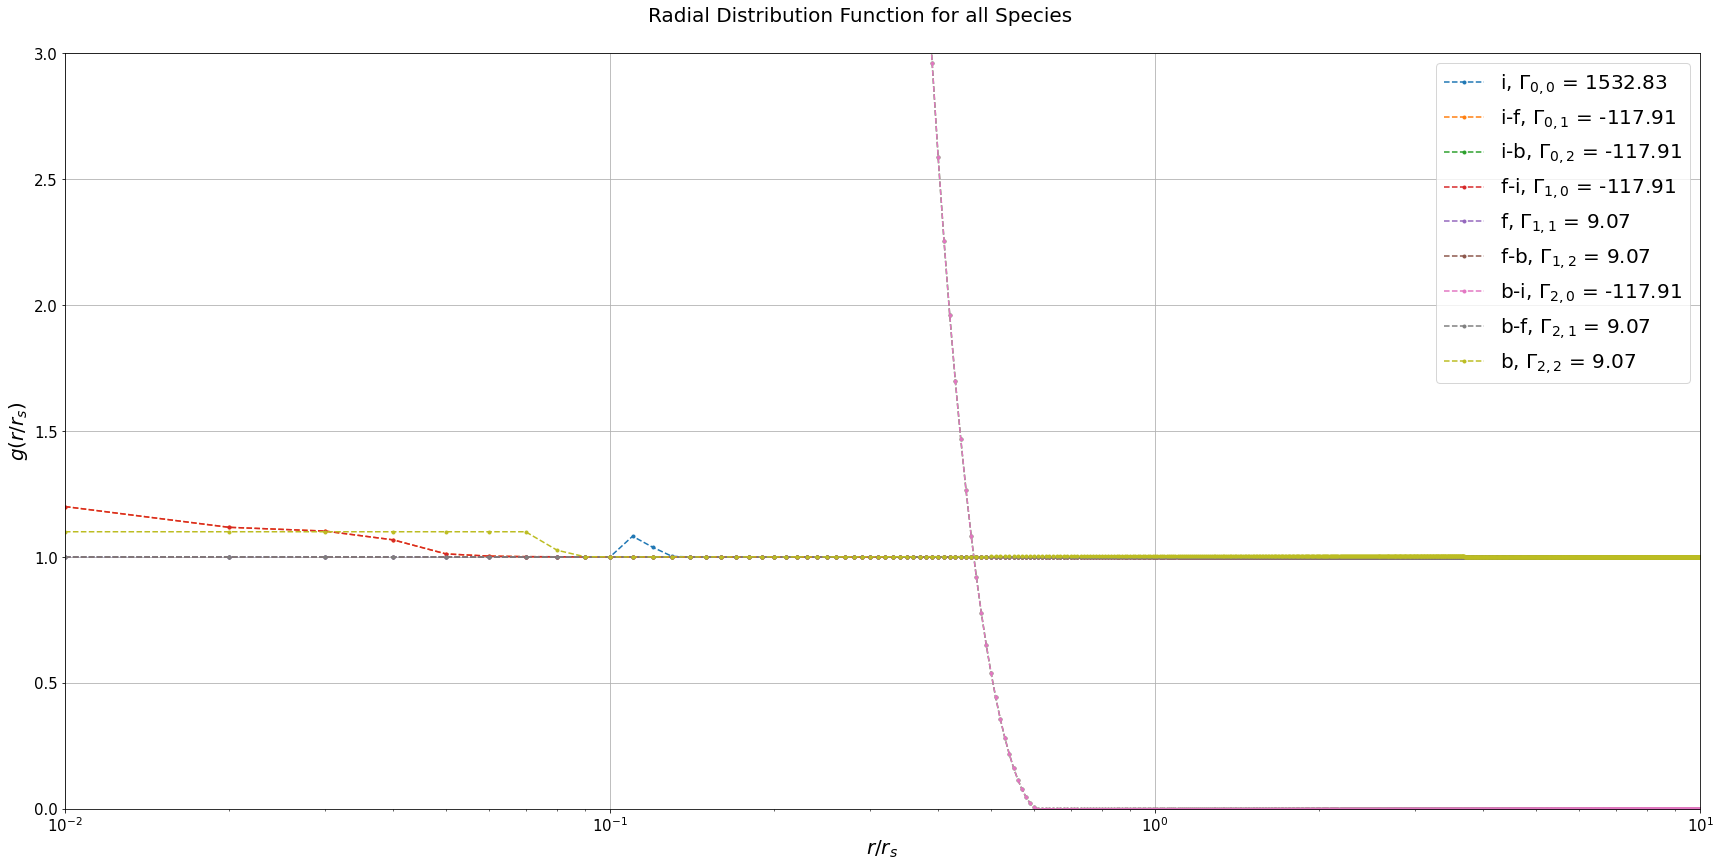

/home/zach/plasma/hnc/hnc_pseudopotential.py:374: RuntimeWarning: overflow encountered in exp
  axs[1,1].plot(self.r_array, np.exp(self.γs_r_matrix + self.βu_l_r_matrix)[species_nums] ,'--.')


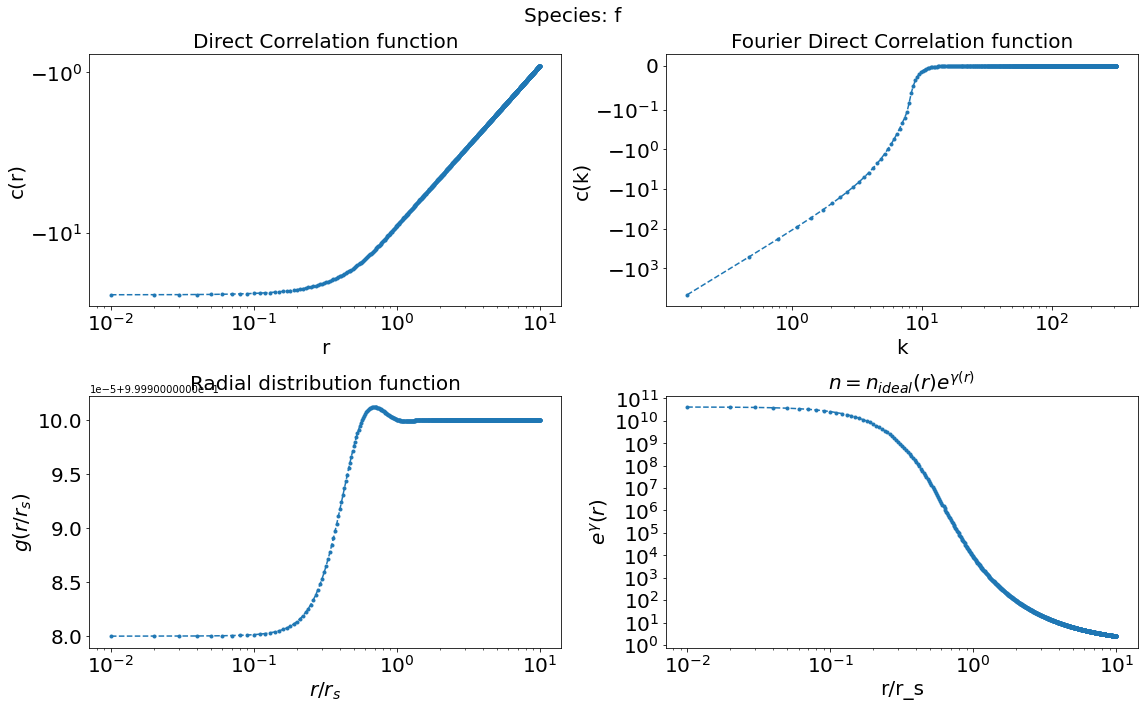

In [37]:
hnc2.plot_g_all_species()
hnc2.plot_g_all_species(gmax=3)#data_to_compare=['/home/zach/plasma/atomic_forces/data/RDF/Al_1.0eV_rs3_KS-MD.txt'], data_names=['KS MD'], gmax=3)
hnc2.plot_species((1,1))